# Detection of Quakes in Mars - A Machine Learning Approach

Mateo Minghi Vega

Enrique Ayala Zapata

Roberto Ibarra Argote

Manuel Romero Vázquez

Iñaki Castillo Fernandez

Emilia Osorio Ferreiro


For the Nasa Space Apps Hackathon, we were given a dataset composed of seismic events recorded on Mars. Such dataset contained the time of the event, a relative time (in seconds), and the frequency recorded.

Plotting the data gives us a much better understanding of the dataset:

  time(%Y-%m-%dT%H:%M:%S.%f)  rel_time(sec)  velocity(c/s)
0    2022-02-03 08:00:00.009           0.00       0.000000
1    2022-02-03 08:00:00.059           0.05       0.000128
2    2022-02-03 08:00:00.109           0.10       0.000703
3    2022-02-03 08:00:00.159           0.15      -0.001124
4    2022-02-03 08:00:00.209           0.20      -0.003985


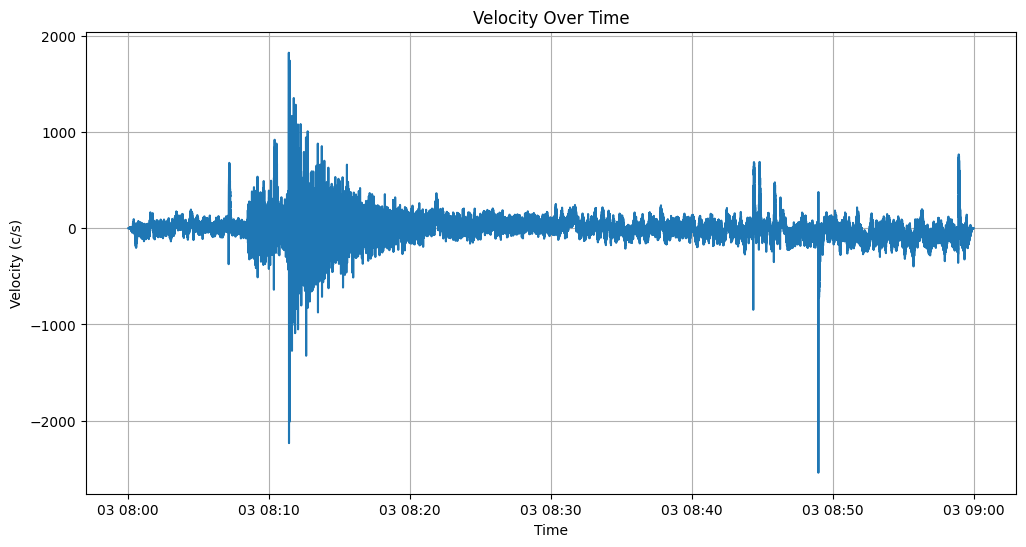

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('dataset1.csv', parse_dates=['time(%Y-%m-%dT%H:%M:%S.%f)'])

print(data.head())

plt.figure(figsize=(12, 6))
plt.plot(data['time(%Y-%m-%dT%H:%M:%S.%f)'], data['velocity(c/s)'], label='Velocity (c/s)')
plt.title('Velocity Over Time')
plt.xlabel('Time')
plt.ylabel('Velocity (c/s)')
plt.grid()
plt.show()


The purpose of the project is to find a way to determine which readings are produced by a quake, so that only relevant data is sent from Mars to Earth, thus reducing the energy needed in these type of missions.

Given the nature of the data, which isn't feature-rich, and doesn't explicitly label which events were produced by quakes; forces us to think of smart algorithms to determine which readings are pertinent. The first approach simply defines a threshold for data spikes. Following this logic, a big enough spike would mean a quake.

In order to determine the threshold, we need to understand the distribution of the data:

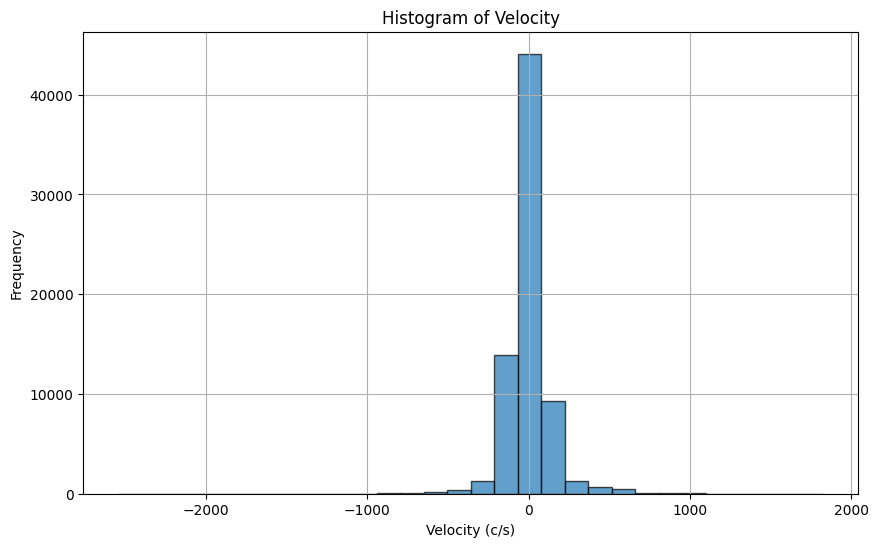

In [2]:
plt.figure(figsize=(10, 6))
plt.hist(data['velocity(c/s)'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Velocity')
plt.xlabel('Velocity (c/s)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

The graph probably isn't too explicit, so by getting its statistical values we can determine its distribution:

In [3]:
from scipy import stats

shapiro_test = stats.shapiro(data['velocity(c/s)'])
print('Statistic: ' + str(shapiro_test.statistic) + " " + 'p-value: ' + str(shapiro_test.pvalue))


Statistic: 0.7978882208257612 p-value: 1.8058815151524003e-124


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 72000.
  res = hypotest_fun_out(*samples, **kwds)


The data follows a normal distribution, meaning that we can use the formula Threshold = μ + (k⋅σ)

--where "k" is a constant multiplier that determines how many standard deviations away from the mean we want to set our threshold. A "k" value of two covers 95% of the data:

In [4]:
mean_velocity = data['velocity(c/s)'].mean()
std_velocity = data['velocity(c/s)'].std()

threshold = mean_velocity + 2 * std_velocity
print('Selected Threshold: ' + str(threshold))

Selected Threshold: 284.4126186698463


Following this logic, our quake detecion would look like this:

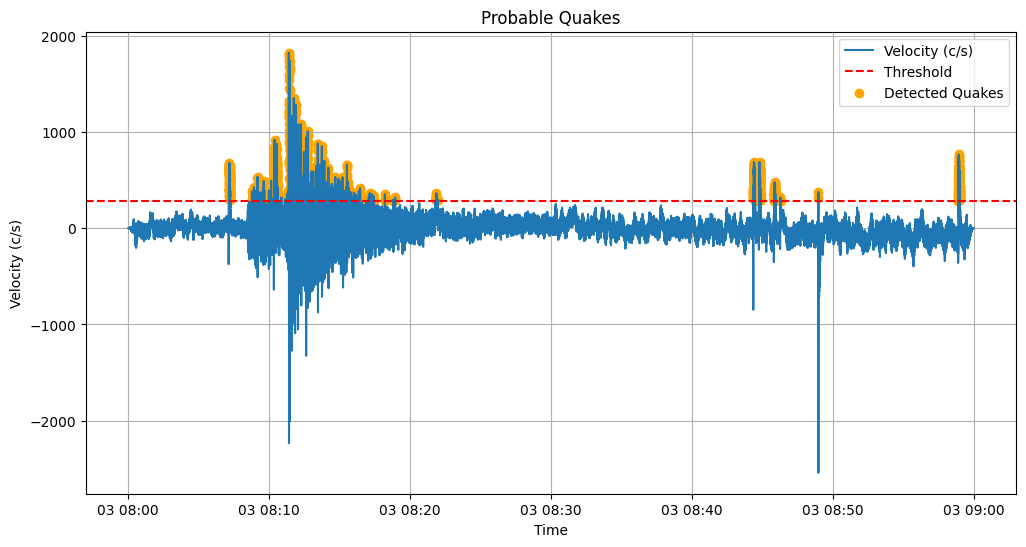

In [5]:
data['Quake'] = np.where(data['velocity(c/s)'] > threshold, 1, 0)

plt.figure(figsize=(12, 6))
plt.plot(data['time(%Y-%m-%dT%H:%M:%S.%f)'], data['velocity(c/s)'], label='Velocity (c/s)')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(data['time(%Y-%m-%dT%H:%M:%S.%f)'][data['Quake'] == 1], data['velocity(c/s)'][data['Quake'] == 1], color='orange', label='Detected Quakes')
plt.title('Probable Quakes')
plt.xlabel('Time')
plt.ylabel('Velocity (c/s)')
plt.legend()
plt.grid()
plt.show()


It clearly isn't a very accurate detection method.
An alternative method is using a machine learning model. Since the data isn't multi-dimentional, and we don't have multiple labeled examples of confirmed quakes, we decided to use an unsupervised machine learning approach. Since it's a classification task, an algorithm like K-means could come in really handy.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time(%Y-%m-%dT%H:%M:%S.%f)  72000 non-null  datetime64[ns]
 1   rel_time(sec)               72000 non-null  float64       
 2   velocity(c/s)               72000 non-null  float64       
 3   Quake                       72000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 2.2 MB


In [7]:
from sklearn.cluster import KMeans

The K-Means algorithm iteratively assigns each datapoint a "k" group, based on its characteristics. They are grouped with their most similar datapoints. We thought it would be smart to use it, as it would group readings together, so we could determine which cluster is composed by quake datapoints.

As far as we could find, there isn't a perfect way to select the number of clusters to use, so we used the famous "elbow method".  

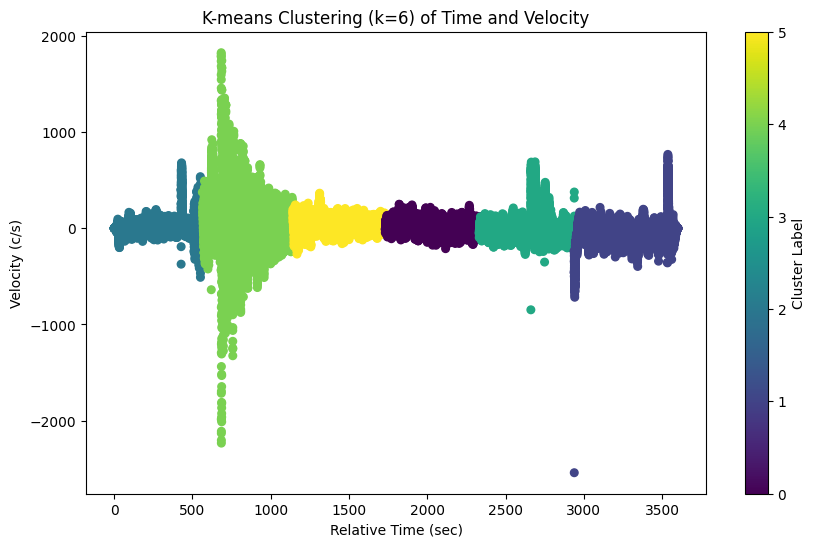

       time(%Y-%m-%dT%H:%M:%S.%f)  rel_time(sec)  velocity(c/s)  Cluster
0      2022-02-03T08:00:00.009000           0.00       0.000000        2
1      2022-02-03T08:00:00.059000           0.05       0.000128        2
2      2022-02-03T08:00:00.109000           0.10       0.000703        2
3      2022-02-03T08:00:00.159000           0.15      -0.001124        2
4      2022-02-03T08:00:00.209000           0.20      -0.003985        2
...                           ...            ...            ...      ...
71995  2022-02-03T08:59:59.759000        3599.75      -0.003213        1
71996  2022-02-03T08:59:59.809000        3599.80      -0.003827        1
71997  2022-02-03T08:59:59.859000        3599.85      -0.002980        1
71998  2022-02-03T08:59:59.909000        3599.90      -0.000506        1
71999  2022-02-03T08:59:59.959000        3599.95       0.000000        1

[72000 rows x 4 columns]


In [8]:
data = pd.read_csv('dataset1.csv')


X = data[['rel_time(sec)', 'velocity(c/s)']].values

k = 6

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

data['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(data['rel_time(sec)'], data['velocity(c/s)'], c=data['Cluster'], cmap='viridis', marker='o', s=30)
plt.title(f'K-means Clustering (k={k}) of Time and Velocity')
plt.xlabel('Relative Time (sec)')
plt.ylabel('Velocity (c/s)')
plt.colorbar(label='Cluster Label')
plt.show()

print(data)


The algorith succesfully separated the data into clusters. It's easy to visualize that cluster number 4 could probably be composed of a quake event. For this particular dataset, we did have knowledge on what the quake event was (relative time of 507 seconds, a frequency of 36.5732727050781).

In [9]:
specific_velocity = 36.573272705078125

cluster_info = data[data['velocity(c/s)'] == specific_velocity]

if not cluster_info.empty:
    print(f"The velocity of {specific_velocity} is found in Cluster {cluster_info['Cluster'].values[0]}.")
else:
    print(f"The velocity of {specific_velocity} is not found in the dataset.")

The velocity of 36.573272705078125 is found in Cluster 2.


That way we know that for a fact that the quake starts within cluster two. However, in case we didn't have any knowledge on when the quake starts, we can make a summary of the clusters, and given their statistical variables determine new thresholds to define which cluster will contain the quake event:

In [10]:
cluster_summary = data.groupby('Cluster')['velocity(c/s)'].describe()
print(cluster_summary)

           count       mean         std          min         25%        50%  \
Cluster                                                                       
0        12026.0  14.334967   65.382996  -212.468658  -31.279312  11.936119   
1        13122.0 -62.342024  107.526677 -2541.654297 -117.042316 -61.776917   
2        11381.0  10.986973   87.299560  -510.360901  -26.809219   4.039391   
3        12191.0  -9.833622  108.404806  -848.039124  -71.326870 -23.285572   
4        11502.0  22.203725  278.711148 -2233.790771 -106.484035  13.556252   
5        11778.0  35.795094   63.555609  -268.571655   -3.319275  34.367367   

                75%          max  
Cluster                           
0         55.736042   249.397430  
1         -8.967396   767.290649  
2         41.308422   679.563843  
3         26.501731   689.609436  
4        143.226910  1824.427368  
5         73.869446   364.011383  


In [11]:
mean_velocity_threshold = 8
std_dev_threshold = 90
min_entries = 10000

print("Custom Thresholds:")
print(f"Mean Velocity Threshold: {mean_velocity_threshold}")
print(f"Standard Deviation Threshold: {std_dev_threshold}")
print(f"Minimum Entries Threshold: {min_entries}")

selected_clusters = cluster_summary[
    (cluster_summary['mean'] > mean_velocity_threshold) &
    (cluster_summary['std'] < std_dev_threshold) &
    (cluster_summary['count'] >= min_entries)
]

print("\nClusters that may contain quakes based on the custom thresholds:")
print(selected_clusters)


Custom Thresholds:
Mean Velocity Threshold: 8
Standard Deviation Threshold: 90
Minimum Entries Threshold: 10000

Clusters that may contain quakes based on the custom thresholds:
           count       mean        std         min        25%        50%  \
Cluster                                                                    
0        12026.0  14.334967  65.382996 -212.468658 -31.279312  11.936119   
2        11381.0  10.986973  87.299560 -510.360901 -26.809219   4.039391   
5        11778.0  35.795094  63.555609 -268.571655  -3.319275  34.367367   

               75%         max  
Cluster                         
0        55.736042  249.397430  
2        41.308422  679.563843  
5        73.869446  364.011383  


Graphing the pertinent cluster:

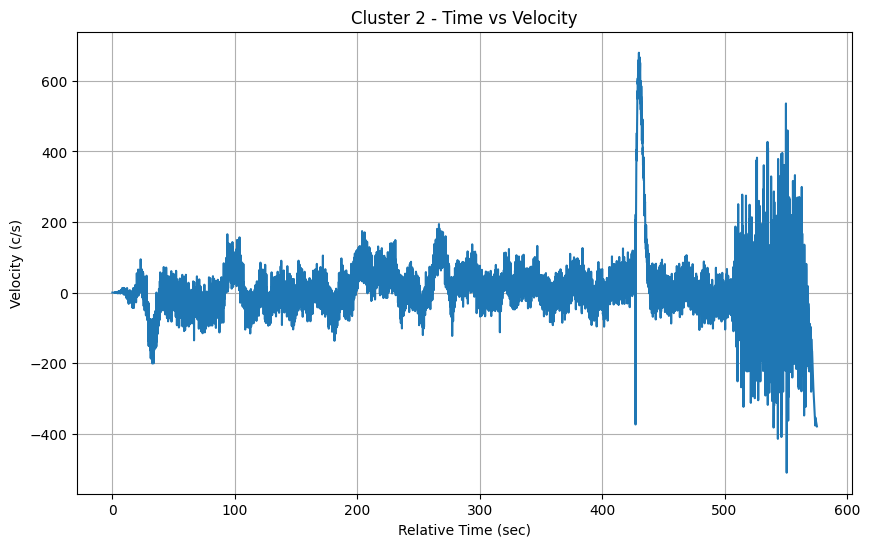

In [12]:
cluster = 2

filtered_data = data[data['Cluster'] == cluster]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['rel_time(sec)'], filtered_data['velocity(c/s)'])
plt.title(f'Cluster {cluster} - Time vs Velocity')
plt.xlabel('Relative Time (sec)')
plt.ylabel('Velocity (c/s)')
plt.grid()
plt.show()
